In [34]:
%run parcel.ipynb

In [35]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [36]:
no = 2
nones = lambda: [None] * no

In [37]:
assert len(setup.rd) == no
assert len(setup.nd) == no

In [38]:
integ, sys = nones(), nones()
for i in range(no):
    integ[i], sys[i] = parcel(
        si = si,
        t = setup.t,
        T0 = 300 * si.kelvin,
        q0 = setup.q0,
        p0 = 1000 * si.hectopascals,
        w = lambda t: setup.w,
        nd = setup.nd[i], 
        rd = setup.rd[i], 
        kp = 1.28,
        dt_max = setup.dt_max
    )

In [39]:
ixs = nones()
ixs[0] = sys[0].ix
ixs[1] = sys[1].ix

fn = sys[0].fn
ph = sys[0].ph

In [40]:
T, p, q, r, t, dr_dt = nones(), nones(), nones(), nones(), nones(), nones()
for i in range(no):
    T[i] = integ[i].y[ixs[i].T] * ixs[i].T_unit
    p[i] = integ[i].y[ixs[i].p] * ixs[i].p_unit
    q[i] = integ[i].y[ixs[i].q] * ixs[i].q_unit
    r[i] = fn.r(integ[i].y[ixs[i].x] * ixs[i].x_unit)
    t[i] = integ[i].t * ixs[i].t_unit

    dr_dt[i] = np.empty_like(r[i]) * ixs[i].r_unit / ixs[i].t_unit
    for j, tau in enumerate(integ[i].t):
        y = integ[i].y[:, j]
        dx_dt = sys[i](tau, y)[ixs[i].x] * ixs[i].x_unit / ixs[i].t_unit
        x = y[ixs[i].x] * ixs[i].x_unit
        dr_dt[i].magnitude[:, j] = dx_dt / fn.dx_dr(fn.r(x))

In [42]:
for i in range(no):
    for j in range(ixs[i].x.stop - ixs[i].x.start):
        print((r[i][j][0]).to(si.nanometre))

1298.2796112834728 nanometer
748.8432941244679 nanometer
2332.569337608753 nanometer


In [43]:
colors = ['purple', 'green', 'red', 'blue','purple']
colors2 = ['gray','black']
color = lambda i, j: colors[2*i + j]
lw = lambda i: 1.5 * (2-i)

<IPython.core.display.Javascript object>


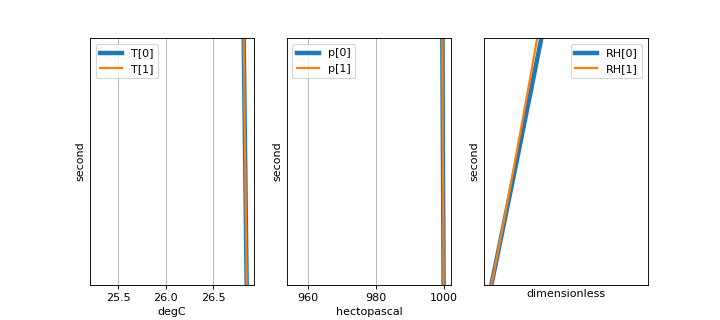

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

for i in range(no):
    ax1.plot(T[0], t[0], label="T["+str(i)+"]", lw=lw(i))
    ax2.plot(p[0], t[0], label="p["+str(i)+"]", lw=lw(i))
    ax3.plot(ph.RH(T[i], p[i], q[i]), t[i], label="RH["+str(i)+"]", lw=lw(i), color = color(i,j))

ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.celsius)

ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.hectopascals)

ax3.grid()
ax3.legend()



In [48]:
r_cr = nones()
for i in range(no):
    r_cr[i] = []
    for j in range(ixs[i].x.stop - ixs[i].x.start):
        r_cr[i].append(ph.r_cr(sys[0].kp, setup.rd[i][j], T[i][:]).to(si.nanometre))
# print(len(r_cr[0][1]))

<IPython.core.display.Javascript object>


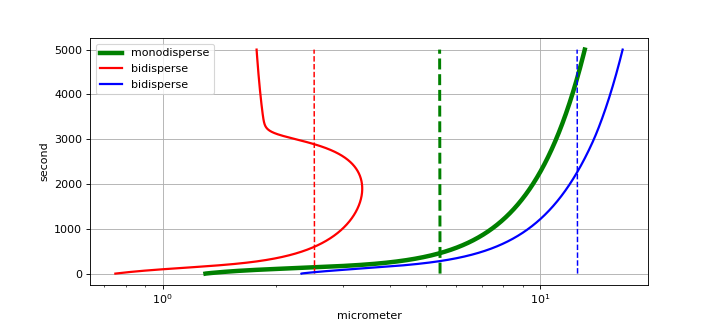

In [49]:
sim = ['monodisperse','bidisperse']
fig, (ax1) = plt.subplots(1, 1, figsize=(9,4))
for i in range(no):
    for j in range(ixs[i].x.stop - ixs[i].x.start):
        plt.plot(r[i][j], t[i], label=sim[i], lw=lw(i), color = color(i,j))
        plt.plot(r_cr[i][j],t[i], '--', color = color(i,j), lw=lw(i)/1.5)
# plt.plot(r_cr,t[0])

plt.xscale('log')
# plt.yscale('log')
plt.grid()
plt.legend()
ax1.xaxis.set_units(si.micrometre)
plt.show()

plt.savefig(setup.figname_radii)

In [52]:
a = nones()
for i in range(no):
    a[i] = []
    for j in range(ixs[i].x.stop - ixs[i].x.start):
        a[i].append(ph.A(T[i][:])/r_cr[i][j])

b = nones()
for i in range(no):
    b[i] = []
    for j in range(ixs[i].x.stop - ixs[i].x.start):
        b[i].append(ph.B(sys[0].kp, setup.rd[i][j])/(r_cr[i][j])**3)
        
print(np.mean(a[0][0]-b[0][0]))
print(np.mean(a[1][0]-b[1][0]))
print(np.mean(a[1][1]-b[1][1]))

1.2809135427205136e-07 gram * liter / kilogram / meter ** 2 / nanometer
2.7560871406819845e-07 gram * liter / kilogram / meter ** 2 / nanometer
5.5330264628106434e-08 gram * liter / kilogram / meter ** 2 / nanometer


<IPython.core.display.Javascript object>


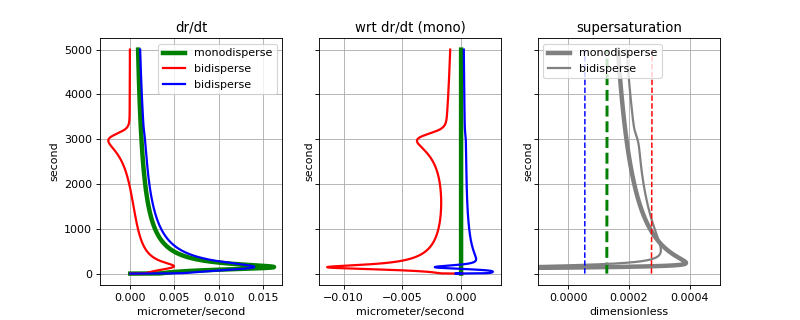

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), sharey=True)
for i in range(no):
    for j in range( ixs[i].x.stop - ixs[i].x.start):
        y = t[0]
        x = np.empty_like(dr_dt[0][0]) * dr_dt[0].units
        x.magnitude[:] = np.interp(y, t[i], dr_dt[i][j]) 
        ax1.plot(x, y, label=sim[i], lw = lw(i),color = color(i,j))
        ax2.plot(x - dr_dt[0][0], y,  lw = lw(i),color = color(i,j))
        if j == 0: ax3.plot(ph.RH(T[i], p[i], q[i])-1, t[i], lw = 1.5*lw(i), color = colors2[i], label = sim[i])
        ax3.plot(a[i][j]-b[i][j], t[i], '--', color = color(i,j), lw=lw(i)/1.5)


#plt.xscale('log')
#plt.xlim(1e-2, .7)
# plt.yscale('log')
ax1.title.set_text('dr/dt')
ax1.grid()
ax1.xaxis.set_units(si.micrometre/si.second)
ax1.legend()

ax2.title.set_text('wrt dr/dt (mono)')
ax2.grid()
ax2.xaxis.set_units(si.nanometer/si.second)
# ax2.legend(loc="upper right")

ax3.title.set_text('supersaturation')
ax3.grid()
ax3.legend(loc = 'lower right')
ax3.set_xlim(setup.S_min, setup.S_max)

plt.show()


plt.savefig(setup.figname_profiles)